**Install Dependencies**

In [1]:
# %%capture
# !pip install -U fastai diffusers transformers jupyter huggingface-hub;

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.6.0'

**Import Dependencies**

In [3]:
from pathlib import Path
import hashlib
import json

from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionPipeline
from fastdownload import FastDownload

import logging
logging.disable(logging.WARNING)

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [4]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Verify cached token**

In [5]:
!ls ~/.huggingface

token


**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML OpenRail-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v1-4 Model Card**](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [**Stable Diffusion v1-5 Model Card**](https://huggingface.co/runwayml/stable-diffusion-v1-5)

**Select a model**

In [6]:
# model_name = "CompVis/stable-diffusion-v1-4"
model_name = "runwayml/stable-diffusion-v1-5"

**Define a Stable Diffusion pipeline**

In [7]:
pipe = StableDiffusionPipeline.from_pretrained(model_name, 
                                               revision="fp16", 
                                               torch_dtype=torch.float16).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

**Define source of custom embedding**

In [8]:
embeds_url = "https://huggingface.co/sd-concepts-library/birb-style/resolve/main/learned_embeds.bin"
embeds_url

'https://huggingface.co/sd-concepts-library/birb-style/resolve/main/learned_embeds.bin'

**Download custom embedding**

In [9]:
embeds_path = FastDownload().download(embeds_url, force=True)

**Verify download**

In [10]:
!ls *.bin

learned_embeds.bin


**Load custom embedding**

In [11]:
embeds_dict = torch.load(embeds_path, map_location="cpu")
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
new_token

'<birb-style>'

**Add token to tokenizer**

In [12]:
assert tokenizer.add_tokens(new_token) == 1, "The token already exists!"
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

**Inspect model checkpoints folder**

In [13]:
!ls ~/.cache/huggingface/diffusers/

models--CompVis--stable-diffusion-v1-4
models--pcuenq--jh_dreambooth_1000
models--runwayml--stable-diffusion-v1-5
models--stabilityai--sd-vae-ft-ema
models--stabilityai--sd-vae-ft-ema-original


In [14]:
ckpt_folder = f"models--{model_name.replace('/', '--')}"
!ls ~/.cache/huggingface/diffusers/{ckpt_folder}

blobs  refs  snapshots


**Define directory to store generated images**

In [15]:
output_dir = Path("./output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

Path('output_dir')

**Define method to display a grid of images**

In [16]:
def image_grid(imgs, rows=1, cols=None):
    if cols is None: cols = math.ceil(len(imgs)/rows)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

**Define text prompt**

In [17]:
prompt = f"A professional digital painting of a robot in the style of {new_token}, gorgeous digital painting"
prompt

'A professional digital painting of a robot in the style of <birb-style>, gorgeous digital painting'

**Define negative prompt**

In [18]:
negative_prompt = ""
negative_prompt

''

In [19]:
negative_prompt = "lowres, bad anatomy, error body, error hair, error arm, error hands, bad hands, error fingers, bad fingers, missing fingers, error legs, bad legs, multiple legs, missing legs, error lighting, error shadow, error reflection, text, error, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
negative_prompt

'lowres, bad anatomy, error body, error hair, error arm, error hands, bad hands, error fingers, bad fingers, missing fingers, error legs, bad legs, multiple legs, missing legs, error lighting, error shadow, error reflection, text, error, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry'

**Initialize random number generator for consistent images**

In [20]:
generator = torch.Generator(device='cuda')
generator.manual_seed(1)

In [21]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['height'] = 512
pipe_config['width'] = 512
pipe_config['steps'] = 50
pipe_config['guidance'] = 15
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]

**Generate images with prompt**

  0%|          | 0/51 [00:00<?, ?it/s]

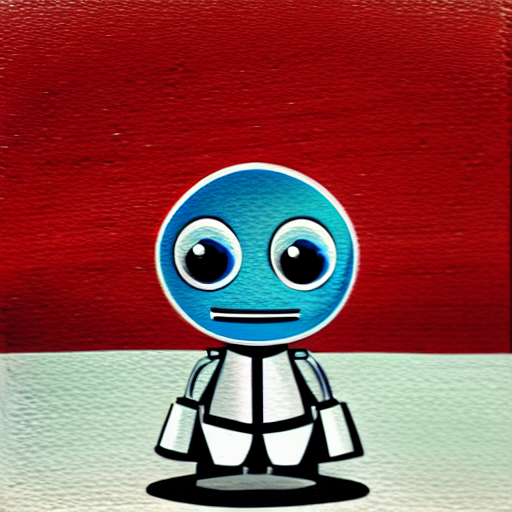

In [22]:
# Specify number of images to generate
num_images = 1
all_images = []
generator_states = []

for i in range(num_images):
    images = pipe(pipe_config['prompt'], 
                  height=pipe_config['height'], 
                  width=pipe_config['width'], 
                  num_inference_steps=pipe_config['steps'], 
                  guidance_scale=pipe_config['guidance'], 
                  negative_prompt=pipe_config['negative_prompt'] if 'negative_prompt' in pipe_config else "",
                  generator=generator).images
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.extend(images)
    torch.cuda.empty_cache()
    

for i, image in enumerate(all_images):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    with open(f"{output_dir}/{img_hash}.json", "w") as write_file:
        json.dump(pipe_config, write_file)
    image.save(f"{output_dir}/{img_hash}.png", format='PNG')
    pipe_config['generator_state'] = generator_states[i]
    
image_grid(all_images, num_images, 1)